#  <span style="text-decoration:underline;">Assignment 3</span>: Predicting Salaries via Classification

## Introduction

In this assignment, you will be working with [US census data](https://raw.githubusercontent.com/lapets/course-data-science/master/assignment-2018-12-03-data.tsv). You can find the schema for the data set [here](https://raw.githubusercontent.com/lapets/course-data-science/master/assignment-2018-12-03-schema.txt). The data is stored in a tab-separated value file in which each line represents an individual person. The data set was extracted from the 1994 US census data. Your goal is to evaluate different models for determining whether a person has an annual salary that is $50,000 or above.  

## Submission

Please use the following invitation link to create your assignment repository for this assignment: [https://classroom.github.com/a/3Af24wlA](https://classroom.github.com/a/3Af24wlA). Include your BU username within your submission by adding it here: **U81612345 xin he**.

Do not delete the output of your code cells. This assignment must be completed **individually** by each student.

## <span style="text-decoration:underline;">Problem 1</span>: Feature Dimension Representations

**<span style="text-decoration:underline;">Part A</span> (20 points):** This data set contains categorical values in its feature dimensions. Most of the algorithms that were presented during lectures can only handle numeric quantities. Thus, it is necessary to create a new feature dimension for every unique value of each categorical variable. To accomplish this, you can use `pandas.get_dummies`. An example is provided below.

In [1]:
# import all the libarary we may need
%matplotlib inline
%config InlineBackend.figure_format='retina'
import sklearn.svm as svm
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.model_selection as cross_validation
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
import sklearn.cluster as cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#import slideUtilities as sl
#import laUtilities as ut
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [2]:
# read data use get_dummies
import pandas as pd
raw_data = {'age': [23, 62, 31, 48, 59],
        'salary': [60000, 100000, 120000, 150000, 95000],
        'education': ['Bachelor', 'Masters', 'PhD', 'Jd', 'Masters']}
df = pd.DataFrame(raw_data, columns = ['age', 'salary', 'education'])
df_edu = pd.get_dummies(df['education'], prefix = 'edu')
df_new = pd.concat([df, df_edu], axis=1)
df_new = df_new.drop( ['education'], axis = 1 )
df_new

age  salary  edu_Bachelor  edu_Jd  edu_Masters  edu_PhD
0   23   60000             1       0            0        0
1   62  100000             0       0            1        0
2   31  120000             0       0            0        1
3   48  150000             0       1            0        0
4   59   95000             0       0            1        0

Convert all categorical feature dimensions within the data set in this way, storing the result as a new data frame.

In [3]:
# read data and convert to data frame
col=['age', 'workclass', 'fnlwgt', 'education', 'education-num','marital-status','occupation','relationship',
         'race','sex','capital-gain','capital-loss','hours-per-week','native-country','salary']
df = pd.read_csv('assignment-2018-12-03-data.tsv',delimiter='\t',encoding='utf-8', header = None)
df.columns = col

In [4]:
# fnlwgt is no use in our assingment
df = df.drop(['fnlwgt'],axis = 1)

In [5]:
# Convert all categorical feature dimensions within the data set to numeric
def data_to_numeric(df, column_names):
    for name in column_names:
        print(name)
        df_new_frame = pd.get_dummies(df[name], prefix = name[:3])
        df = pd.concat([df, df_new_frame], axis=1)
    df = df.drop(column_names, axis = 1 )
    return df
# all the data to be convert
dummies = ['workclass','education','marital-status','occupation','relationship','race',
            'sex','native-country']
df = data_to_numeric(df, dummies)
# filter out people with ? feature
df = df[(df['wor_?'] == 0)]
df = df.drop(['wor_?'], axis = 1)
# replace salary > 50K to 1 and < 50K to 0
df['salary'].replace('<=50K', 0,inplace=True)
df['salary'].replace('>50K', 1,inplace=True)
df = df.astype('float64')
df

workclass
education
marital-status
occupation
relationship
race
sex
native-country


age  education-num  capital-gain  capital-loss  hours-per-week  \
0      39.0           13.0        2174.0           0.0            40.0   
1      50.0           13.0           0.0           0.0            13.0   
2      38.0            9.0           0.0           0.0            40.0   
3      53.0            7.0           0.0           0.0            40.0   
4      28.0           13.0           0.0           0.0            40.0   
5      37.0           14.0           0.0           0.0            40.0   
6      49.0            5.0           0.0           0.0            16.0   
7      52.0            9.0           0.0           0.0            45.0   
8      31.0           14.0       14084.0           0.0            50.0   
9      42.0           13.0        5178.0           0.0            40.0   
10     37.0           10.0           0.0           0.0            80.0   
11     30.0           13.0           0.0           0.0            40.0   
12     23.0           13.0           0.0           0.0            30.0   
13     32.0           12.0           0.0           0.0            50.0   
14     40.0           11.0           0.0           0.0            40.0   
15     34.0            4.0           0.0           0.0            45.0   
16     25.0            9.0           0.0           0.0            35.0   
17     32.0            9.0           0.0           0.0            40.0   
18     38.0            7.0           0.0           0.0            50.0   
19     43.0           14.0           0.0           0.0            45.0   
20     40.0           16.0           0.0           0.0            60.0   
21     54.0            9.0           0.0           0.0            20.0   
22     35.0            5.0           0.0           0.0            40.0   
23     43.0            7.0           0.0        2042.0            40.0   
24     59.0            9.0           0.0           0.0            40.0   
25     56.0           13.0           0.0           0.0            40.0   
26     19.0            9.0           0.0           0.0            40.0   
28     39.0            9.0           0.0           0.0            80.0   
29     49.0            9.0           0.0           0.0            40.0   
30     23.0           12.0           0.0           0.0            52.0   
...     ...            ...           ...           ...             ...   
46479  30.0           15.0           0.0           0.0            80.0   
46480  21.0            9.0           0.0           0.0            30.0   
46481  57.0           10.0        7688.0           0.0            60.0   
46482  51.0           13.0           0.0        1590.0            40.0   
46483  37.0           14.0           0.0           0.0            42.0   
46484  42.0           11.0           0.0           0.0            50.0   
46485  32.0           11.0        5178.0           0.0            60.0   
46486  51.0           13.0           0.0           0.0            40.0   
46487  24.0            7.0           0.0           0.0            40.0   
46488  25.0            9.0           0.0           0.0            40.0   
46489  31.0            9.0           0.0           0.0            40.0   
46490  49.0            9.0           0.0           0.0            40.0   
46492  60.0           11.0        7688.0           0.0            40.0   
46493  38.0           14.0           0.0           0.0            50.0   
46494  43.0           14.0           0.0        1902.0            50.0   
46495  23.0            9.0           0.0           0.0            40.0   
46496  73.0           10.0           0.0           0.0            40.0   
46497  35.0           10.0           0.0           0.0            40.0   
46498  66.0            9.0           0.0           0.0             8.0   
46499  40.0           15.0       15024.0           0.0            55.0   
46500  51.0            9.0           0.0           0.0            40.0   
46501  22.0           10.0           0.0           0.0            40.0   
46502  64.0 

In [6]:
# columns we get
df.columns

Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'salary', 'wor_Federal-gov', 'wor_Local-gov',
       'wor_Never-worked', 'wor_Private',
       ...
       'nat_Portugal', 'nat_Puerto-Rico', 'nat_Scotland', 'nat_South',
       'nat_Taiwan', 'nat_Thailand', 'nat_Trinadad&Tobago',
       'nat_United-States', 'nat_Vietnam', 'nat_Yugoslavia'],
      dtype='object', length=107)

## <span style="text-decoration:underline;">Problem 2</span>: Classification Methods

For each part below, you may use either the data in its original form or the transformed representation of the data that you generated in Problem 1.

**<span style="text-decoration:underline;">Part A</span> (20 points):** Use $k$-nearest neighbors to implement an algorithm that predicts the whether an individual has an annual salary of 50,000 dollars or above. Note that the target feature dimension is discrete; you may use a boolean value or $\{0,1\}$. Explain how you chose $k$ and report the accuracy of your model on the data. Using `KNeighborsClassifier` is permitted.

In [7]:
# filter out training data
X = df.drop(['salary'], axis = 1).values
y = df[['salary']].copy().values
y = y.flatten()
X

array([[3.900e+01, 1.300e+01, 2.174e+03, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e+01, 1.300e+01, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [3.800e+01, 9.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [4.800e+01, 9.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [6.100e+01, 9.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [3.100e+01, 9.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [8]:
# get only first 500 to feed to svm since its too slow
X_svm = df.drop(['salary'], axis = 1).head(500).values
y_svm = df[['salary']].head(500).copy().values
y_svm = y_svm.flatten()

In [9]:
# make 80% of data to train and 20% to predict
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [10]:
# scale all the data fetures to make the result more acurate
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 
X_train

array([[ 1.55682967, -0.04932818, -0.14666262, ...,  0.3415394 ,
        -0.04308289, -0.02201786],
       [ 0.41725821, -0.04932818, -0.14666262, ...,  0.3415394 ,
        -0.04308289, -0.02201786],
       [ 0.87308679, -0.04932818, -0.14666262, ...,  0.3415394 ,
        -0.04308289, -0.02201786],
       ...,
       [-0.64634182, -0.43814642, -0.14666262, ...,  0.3415394 ,
        -0.04308289, -0.02201786],
       [ 0.87308679, -0.04932818, -0.14666262, ...,  0.3415394 ,
        -0.04308289, -0.02201786],
       [-0.11454181,  1.11712653, -0.14666262, ...,  0.3415394 ,
        -0.04308289, -0.02201786]])

In [11]:
error = []
# Calculating error for K values between 1 and 7
for i in range(1, 8):  
    print(i)
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

1
2
3
4
5
6
7


In [12]:
error

[0.21183445445217192,
 0.19895108881541443,
 0.18937407365180708,
 0.1813932276821343,
 0.18013909474404285,
 0.17603465967392543,
 0.1742104663094288]

Text(0, 0.5, 'Mean Error')

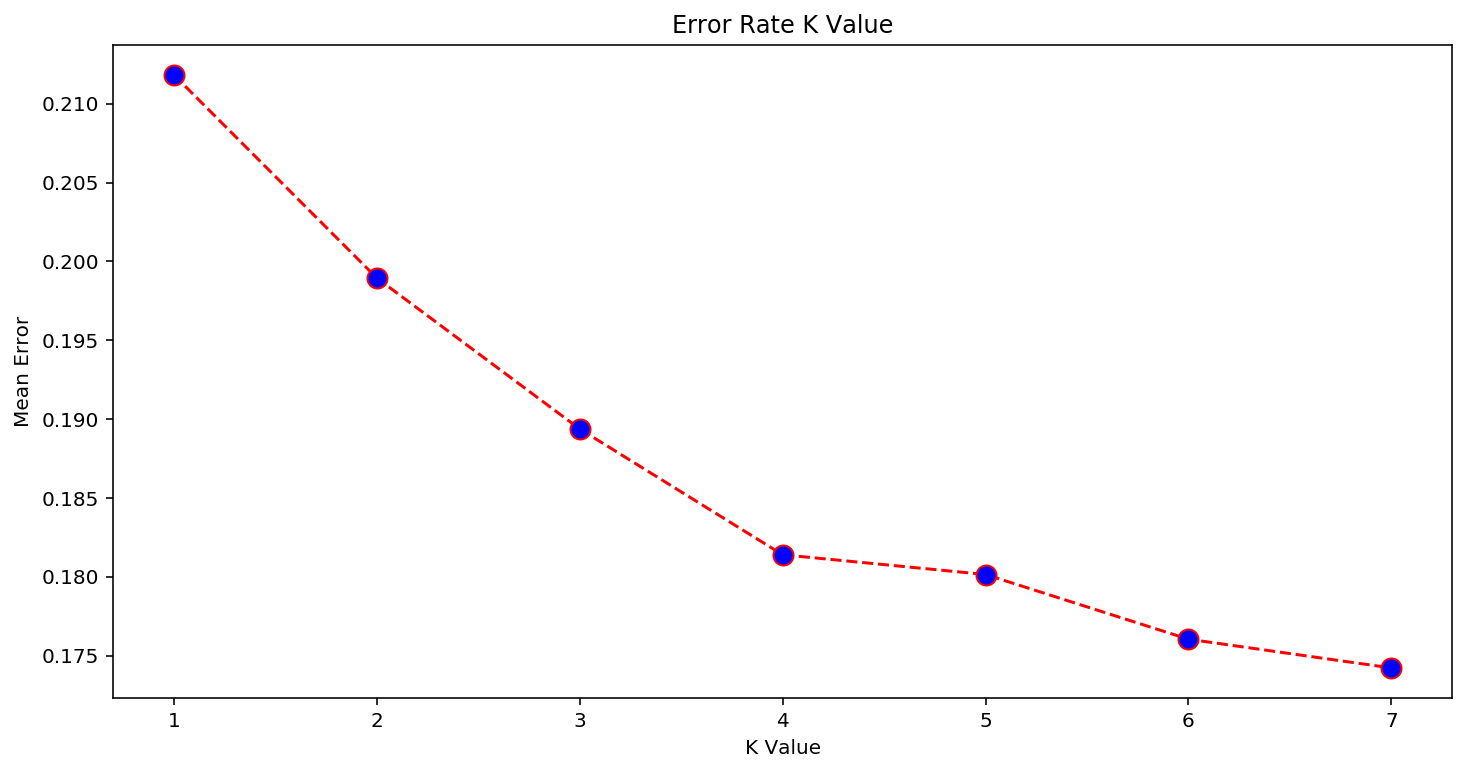

In [13]:
# draw the error plot to find a good k
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 8), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

In [14]:
(X_train, X_test, y_train, y_test) = cross_validation.train_test_split(
        X, y,
        test_size=0.2)

In [15]:
# from this plot, I chose 6 as our k, because the error rate is low enough and when k gets bigger its not grow so fast.
# On the other hand, when k gets bigger, the calculate time grows fast.
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
pred_test = knn.predict(X_test)
print('Accuracy on test data: {}'.format(knn.score(X_test, y_test)))
y_pred_train = knn.predict(X_train)
print('DT accuracy on training data: ', knn.score(X_train, y_train))
# this is to test the acuuracy of test and training data, this result is good

Accuracy on test data: 0.8447155398472238
DT accuracy on training data:  0.8842207273971041


In [16]:
# try to get some report about this method
accuracy = cross_validation.cross_val_score(knn, 
            X, y, scoring='accuracy',verbose = 1, cv = 5)
# i will run every method for 5 times to calculate the mean and std

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.1s finished


In [17]:
# this is the mean acurracy of knn 
accuracy.mean()

0.8493216161161161

In [18]:
# this is to tell us the viarition of the data
accuracy.std()

0.00261319088619175

**<span style="text-decoration:underline;">Part B</span> (20 points):** Use [decision trees](http://scikit-learn.org/stable/modules/tree.html) to build a model that predicts the same target feature dimension (income of 50,000 or above). Report your accuracy and compare it to your results from part (a). Using `tree` from `sklearn` is permitted.

In [19]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_test = dtc.predict(X_test)
print('DT accuracy on test data: ', dtc.score(X_test, y_test))
y_pred_train = dtc.predict(X_train)
print('DT accuracy on training data: ', dtc.score(X_train, y_train))
# A Decision Tree model is a good at this problem as Decision Tree models are particularly 
# adept at binary classification, the 97 percent acuuracy on training data is cuz overfitting

DT accuracy on test data:  0.8233952798996693
DT accuracy on training data:  0.9738627294493216


In [20]:
accuracy = cross_validation.cross_val_score(dtc, 
            X, y, scoring='accuracy',verbose = 1, cv = 5)
accuracy.mean()
# the accuracy is lower than knn

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


0.8163038120600605

In [21]:
# the variation is worse than knn, so it varies more
accuracy.std()

0.003569390445557849

**<span style="text-decoration:underline;">Part C</span> (20 points):** Build a support vector machine model that solves the same problem. Report your accuracy and compare it to your results from parts (a) and (b). 

In [22]:
# filter out training data
X = df.drop(['salary'], axis = 1).values
y = df[['salary']].copy().values
y = y.flatten()
X

array([[3.900e+01, 1.300e+01, 2.174e+03, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e+01, 1.300e+01, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [3.800e+01, 9.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [4.800e+01, 9.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [6.100e+01, 9.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [3.100e+01, 9.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [23]:
svc = svm.SVC(kernel='linear')

In [24]:
accuracy = cross_validation.cross_val_score(svc, 
            X_svm, y_svm, scoring='accuracy',verbose = 1, cv = 5)
accuracy.mean()
# this acuraccy is worse than knn and near decition tree.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.4min finished


0.8243658365836584

In [25]:
# this data varies a lot, worse than knn and decition tree
accuracy.std()

0.04434836184135587

**<span style="text-decoration:underline;">Part D</span> (20 points):** Build a logistic regression model that solves the same problem. Report your accuracy and compare it to your results from parts (a), (b), and (c). 

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set:' , logreg.score(X_test, y_test))
# test accuracy

Accuracy of logistic regression classifier on test set: 0.8420932618857598


In [27]:
accuracy = cross_validation.cross_val_score(logreg, 
            X, y, scoring='accuracy',verbose = 1, cv = 5)
accuracy.mean()
# this one is as good as knn and better than decition tree and svm on trainning data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


0.8471783084770805

In [28]:
# this method not varies a lot, its the second good
accuracy.std()

0.0030525859892499623

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90      6560
         1.0       0.72      0.60      0.66      2211

   micro avg       0.84      0.84      0.84      8771
   macro avg       0.80      0.76      0.78      8771
weighted avg       0.84      0.84      0.84      8771

